In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import os

# modules
from utils import *
from dataset import *
from vgg19min import *
from plotgrid import PlotGrid
from score import *
from trainer import *
from logger import *

# pytorch
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms


In [2]:
requirements = {
    torch: '1'
}

check_requirements(requirements)

In [3]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cuda'

In [4]:
ROOT_PATH = pathJoin(os.sep, 'var', 'node433', 'local', 'gulfaraz')

In [5]:
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

raw_transforms = transforms.Compose([
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize
])

def load_data(dataset_name, split):
    dataset_path = os.path.join(ROOT_PATH, 'datasets', dataset_name)

    istrain = split == 'train'
    transforms = train_transforms if istrain else test_transforms
    batch_size = TRAIN_BATCH_SIZE if istrain else TEST_BATCH_SIZE

    dataset = MiniImageNetDataset(dataset_path, split=split, transforms=transforms)#raw_transforms)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=istrain, num_workers=8)

    print('{} dataset {} has {} datapoints in {} batches'.format(split, dataset_name, len(dataset), len(loader)))

    return dataset, loader

original_train_dataset, original_train_loader = load_data('miniimagenet', 'train')
original_val_dataset, original_val_loader = load_data('miniimagenet', 'val')

stylized_train_dataset, stylized_train_loader = load_data('stylized-miniimagenet-1.0', 'train')
stylized_val_dataset, stylized_val_loader = load_data('stylized-miniimagenet-1.0', 'val')
'''

miniimagenet_dataset_path = os.path.join(ROOT_PATH, 'datasets', 'miniimagenet')

original_train_dataset = MiniImageNetDataset(miniimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
original_val_dataset = MiniImageNetDataset(miniimagenet_dataset_path, split='val', transforms=test_transforms)

original_train_loader = DataLoader(original_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
original_val_loader = DataLoader(original_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

stylized_miniimagenet_dataset_path = os.path.join(ROOT_PATH, 'datasets', 'stylized-miniimagenet-1.0')

stylized_train_dataset = MiniImageNetDataset(stylized_miniimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
stylized_val_dataset = MiniImageNetDataset(stylized_miniimagenet_dataset_path, split='val', transforms=test_transforms)

stylized_train_loader = DataLoader(stylized_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
stylized_val_loader = DataLoader(stylized_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)
'''
for dataset, loader in [
    (original_train_dataset, original_train_loader),
    (original_val_dataset, original_val_loader),
    (stylized_train_dataset, stylized_train_loader),
    (stylized_val_dataset, stylized_val_loader)
]:
    print('{} Datapoints in {} Batches'.format(len(dataset), len(loader)))

dataset_names = [
    'stylized-miniimagenet-1.0', 'stylized-miniimagenet-0.9', 'stylized-miniimagenet-0.8',
    'stylized-miniimagenet-0.7', 'stylized-miniimagenet-0.6', 'stylized-miniimagenet-0.5',
    'stylized-miniimagenet-0.4', 'stylized-miniimagenet-0.3', 'stylized-miniimagenet-0.2',
    'stylized-miniimagenet-0.1', 'stylized-miniimagenet-0.0', 'miniimagenet'
]


 56%|█████▌    | 5593/10000 [00:00<00:00, 27914.01it/s]

train dataset miniimagenet has 100000 datapoints in 6250 batches


  3%|▎         | 2707/100000 [00:00<00:03, 27064.67it/s]

val dataset miniimagenet has 10000 datapoints in 625 batches


 56%|█████▋    | 5639/10000 [00:00<00:00, 28107.65it/s]

train dataset stylized-miniimagenet-1.0 has 100000 datapoints in 6250 batches


100%|██████████| 10000/10000 [00:00<00:00, 28025.70it/s]

val dataset stylized-miniimagenet-1.0 has 10000 datapoints in 625 batches
100000 Datapoints in 6250 Batches
10000 Datapoints in 625 Batches
100000 Datapoints in 6250 Batches
10000 Datapoints in 625 Batches


<IPython.core.display.Javascript object>


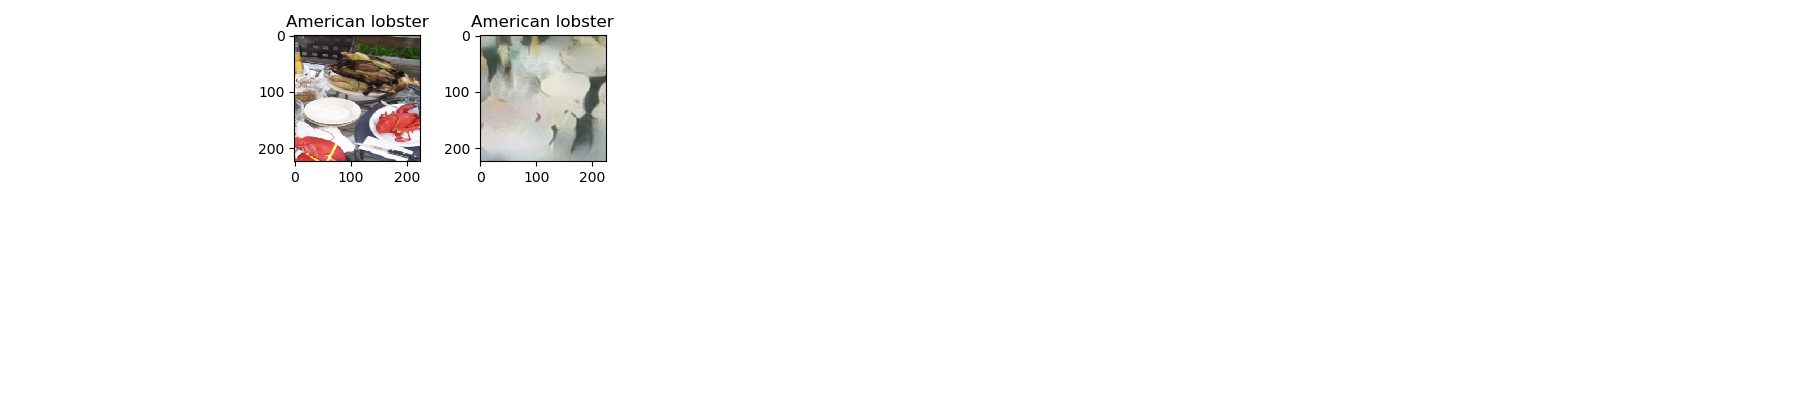

In [6]:
image_grid = PlotGrid(figsize=(9,2))

In [7]:
for index, image in enumerate(original_train_dataset):
    index_image = original_train_dataset.INDEX_IMAGE
    index_label = original_train_dataset.INDEX_LABEL
    
    # get datapoints
    original = original_train_dataset[index]
    stylized = stylized_train_dataset[index]
    
    # get images
    img = original[index_image]
    stylized_img = stylized[index_image]
    
    # plot images
    image_grid.plot((1, 2, 1), toImage(img), title=original[index_label])
    image_grid.plot((1, 2, 2), toImage(stylized_img), title=stylized[index_label])
    if (index + 1) == 9:
        break


In [8]:
supported_models = {
#     'vgg19_in_pretrained_in_tuned_min': create_vgg19_in_pretrained,
#     'vgg19_in_batch_stats_pretrained_in_tuned_min': create_vgg19_in_pretrained, # create_vgg19_in_batch_stats_pretrained / create_vgg19_in_bs_eval / create_vgg19_in_pretrained
#     'vgg19_pretrained_in_tuned_min': create_vgg19_pretrained,
#     'vgg19_scratch_min': create_vgg19_scratch,
#     'vgg19_bn_pretrained_in_tuned_min': create_vgg19_bn_tune_fc,
#     'vgg19_in_single_tune_all': create_vgg19_in_single_tune_all,
#     'vgg19_in_bs_single_tune_all': create_vgg19_in_bs_single_tune_all,
#     'vgg19_in_all_tune_all': create_vgg19_in_all_tune_all,
#     'vgg19_in_bs_all_tune_all': create_vgg19_in_bs_all_tune_all
#     'vgg19_cosine_tune_all_no_similarity': create_vgg19_cosine_tune_all
#     'vgg19_custom_cosine_similarity_weight_0.04_tune_all_grad_clip_50_pos_loss': create_vgg19_cosine_tune_all

    'vgg19_vanilla_similarity_0.04_tune_all': create_vgg19_vanilla_similarity_tune_all,
    'vgg19_in_single_similarity_0.04_tune_all': create_vgg19_in_single_similarity_tune_all,
    'vgg19_bn_all_similarity_tune_fc': create_vgg19_bn_all_similarity_tune_fc,
    'vgg19_bn_all_similarity_tune_all': create_vgg19_bn_all_similarity_tune_all,
}

sanity(supported_models, original_train_loader, device)


vgg19_vanilla_similarity_0.04_tune_all
vgg19_in_single_similarity_0.04_tune_all
vgg19_bn_all_similarity_tune_fc
vgg19_bn_all_similarity_tune_all


In [ ]:
epochs = 50
similarity_weight = 0.04

# setup log directory
log_directory = pathJoin('run_logs')
os.makedirs(log_directory, exist_ok=True)

for model_type in supported_models:

    # original
    run_name = '{}'.format(model_type)
    logger = create_logger(log_directory, run_name)
    logger.info('Run Name {}'.format(run_name))
    model = supported_models[model_type]()
    run(run_name, model, epochs, monitor, logger, original_train_loader, original_val_loader, device, similarity_weight=similarity_weight, load_data=load_data)

#     # stylized
#     run_name = 'stylized_{}'.format(model_type)
#     logger = create_logger(log_directory, run_name)
#     logger.info('Run Name {}'.format(run_name))
#     model = supported_models[model_type]()
#     run(run_name, model, training, epochs, monitor, logger, stylized_train_loader, stylized_val_loader)

    del model
    torch.cuda.empty_cache()


## Check Performance

In [9]:
models_directory = pathJoin(ROOT_PATH, 'models')

perf(supported_models, models_directory, dataset_names, device, load_data=load_data)

vgg19_vanilla_similarity_0.04_tune_all
/var/node433/local/gulfaraz/models/vgg19_vanilla_similarity_0.04_tune_all.ckpt


 27%|██▋       | 2748/10000 [00:00<00:00, 27475.64it/s]

Epoch: 40


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-1.0 has 10000 datapoints in 625 batches


 28%|██▊       | 2761/10000 [00:00<00:00, 27606.87it/s]

stylized-miniimagenet-1.0: Top1: 0.0602 Top5: 0.1599


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.9 has 10000 datapoints in 625 batches


 28%|██▊       | 2750/10000 [00:00<00:00, 27497.34it/s]

stylized-miniimagenet-0.9: Top1: 0.0974 Top5: 0.2236


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.8 has 10000 datapoints in 625 batches


  0%|          | 0/10000 [00:00<?, ?it/s]

stylized-miniimagenet-0.8: Top1: 0.1496 Top5: 0.3184


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.7 has 10000 datapoints in 625 batches


  0%|          | 0/10000 [00:00<?, ?it/s]

stylized-miniimagenet-0.7: Top1: 0.2209 Top5: 0.4288


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.6 has 10000 datapoints in 625 batches


  0%|          | 0/10000 [00:00<?, ?it/s]

stylized-miniimagenet-0.6: Top1: 0.3065 Top5: 0.5486


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.5 has 10000 datapoints in 625 batches


  0%|          | 0/10000 [00:00<?, ?it/s]

stylized-miniimagenet-0.5: Top1: 0.4001 Top5: 0.6465


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.4 has 10000 datapoints in 625 batches


  0%|          | 0/10000 [00:00<?, ?it/s]

stylized-miniimagenet-0.4: Top1: 0.4757 Top5: 0.7296


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.3 has 10000 datapoints in 625 batches


  0%|          | 0/10000 [00:00<?, ?it/s]

stylized-miniimagenet-0.3: Top1: 0.5422 Top5: 0.7871


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.2 has 10000 datapoints in 625 batches


100%|██████████| 625/625 [01:13<00:00,  8.50it/s]


stylized-miniimagenet-0.2: Top1: 0.5847 Top5: 0.8177


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.1 has 10000 datapoints in 625 batches


 28%|██▊       | 2779/10000 [00:00<00:00, 27785.46it/s]

stylized-miniimagenet-0.1: Top1: 0.6042 Top5: 0.8393


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.0 has 10000 datapoints in 625 batches


 27%|██▋       | 2678/10000 [00:00<00:00, 26775.30it/s]

stylized-miniimagenet-0.0: Top1: 0.6137 Top5: 0.8432


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset miniimagenet has 10000 datapoints in 625 batches


100%|██████████| 625/625 [01:14<00:00,  8.62it/s]


miniimagenet: Top1: 0.7997 Top5: 0.9416
Train: Loss: 2.3280 Top1 Accuracy: 0.7921 Top5 Accuracy: 0.9278
Validation: Loss: 2.3342 Top1 Accuracy: 0.7997 Top5 Accuracy: 0.9416
vgg19_in_single_similarity_0.04_tune_all
/var/node433/local/gulfaraz/models/vgg19_in_single_similarity_0.04_tune_all.ckpt


 28%|██▊       | 2777/10000 [00:00<00:00, 27763.61it/s]

Epoch: 50


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-1.0 has 10000 datapoints in 625 batches


 55%|█████▌    | 5549/10000 [00:00<00:00, 27752.43it/s]

stylized-miniimagenet-1.0: Top1: 0.0403 Top5: 0.1216


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.9 has 10000 datapoints in 625 batches


 55%|█████▌    | 5544/10000 [00:00<00:00, 27648.53it/s]

stylized-miniimagenet-0.9: Top1: 0.0601 Top5: 0.1679


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.8 has 10000 datapoints in 625 batches


 56%|█████▌    | 5554/10000 [00:00<00:00, 27819.38it/s]

stylized-miniimagenet-0.8: Top1: 0.0872 Top5: 0.2337


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.7 has 10000 datapoints in 625 batches


 55%|█████▍    | 5450/10000 [00:00<00:00, 27149.91it/s]

stylized-miniimagenet-0.7: Top1: 0.1307 Top5: 0.3138


  0%|          | 0/625 [00:00<?, ?it/s]

val dataset stylized-miniimagenet-0.6 has 10000 datapoints in 625 batches


  7%|▋         | 44/625 [00:05<01:08,  8.50it/s]


KeyboardInterrupt: 